# Classification

In End to end machine learning project I mentioned that the most common supervised learning tasks are regression (predicting values) and classification (predicting classes). Also we explored a regression task, predicting housing values, using various algorithms such as Linear Regression, Decision Trees, and Random Forests (which will be explained in further detail in later chapters). Now we will turn our attention to classification systems.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

## MNIST

![01](https://i0.wp.com/syncedreview.com/wp-content/uploads/2019/06/MNIST.png)

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:

* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels

Let’s look at these arrays:

In [4]:
X, y = mnist["data"], mnist["target"]

print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (70000, 784)
y: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

In [5]:
28 * 28

784

Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

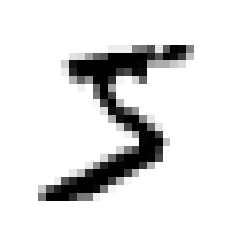

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [8]:
y[0]

'5'

In [9]:
# Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:
y = y.astype(np.uint8)

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

To give you a feel for the complexity of the classification task, the figure below shows a few more images from the MNIST dataset.

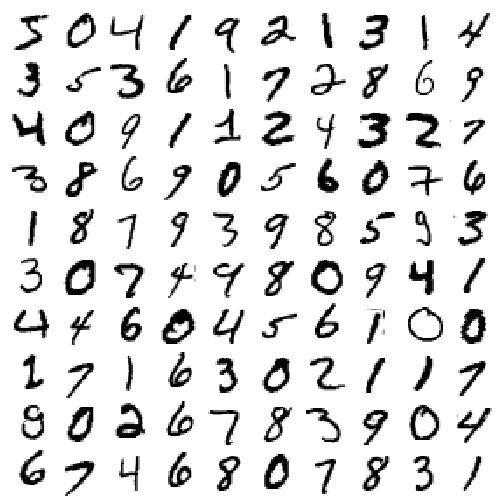

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [12]:
y[0]

5

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

# Binary classifier

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set:

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

<div class="alert alert-warning" role="alert">
    <h4 class="alert-heading">DICA</h4>
    The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.
</div>

Now we can use it to detect images of the number 5:

In [16]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation, just as you did in the last project.

#### IMPLEMENTING CROSS-VALIDATION
    
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and it prints the same result:

```python
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495
```

> The StratifiedKFold class performs stratified sampling (as explained in Notebook 01) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let’s use the cross_val_score() function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Notebook 01):

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/vitormeriat/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
# Can you guess this model’s accuracy? Let’s find out:

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier (Equation 3-1).

Equation 3-1. Precision

$precision=\dfrac {TP}{TP+FP}$

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier (Equation 3-2).

Equation 3-2. Recall

$recall=\dfrac {TP}{TP+FN}$

FN is, of course, the number of false negatives.

If you are confused about the confusion matrix, Figure 3-2 may help.

![02](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0302.png)

Figure 3-2. An illustrated confusion matrix shows examples of true negatives (top left), false positives (top right), false negatives (lower left), and true positives (lower right)

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
4096 / (4096 + 1522)

0.7290850836596654

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
4096 / (4096 + 1325)

0.7555801512636044

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover, it only detects 75.6% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$$\Large F_{1}=\dfrac {2}{\dfrac {1}{precision}+\dfrac {1}{recall}}=2\times \dfrac {precision \times recall}{precision + recall}=\dfrac {TP}{TP+\dfrac {FN+FP}{2}}$$

To compute the F1 score, simply call the f1_score() function:

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
4096 / (4096 + (1522 + 1325) / 2)

0.7420962043663375

The $F1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

#### Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Figure 3-3 shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![123](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0303.png)

Figure 3-3. In this precision/recall trade-off, images are ranked by their classifier score, and those above the chosen decision threshold are considered positive; the higher the threshold, the lower the recall, but (in general) the higher the precision

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

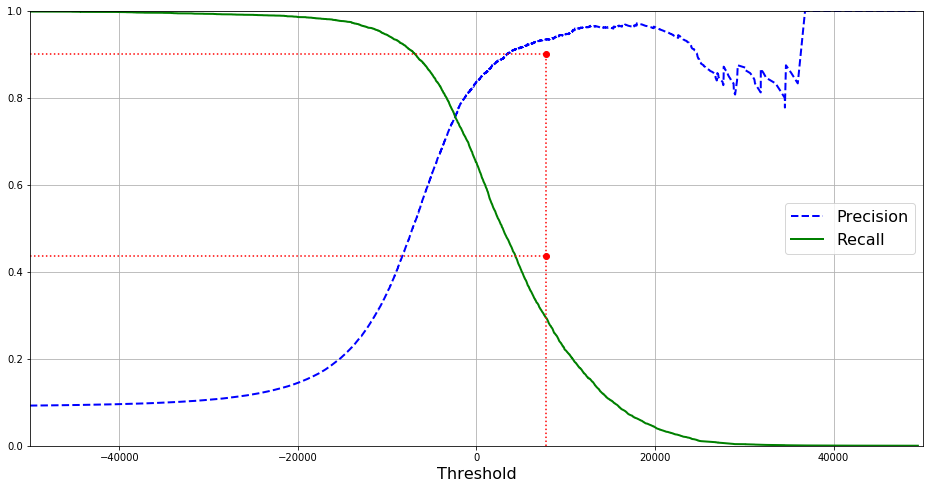

In [37]:
plt.figure(figsize=(16, 8))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown
#save_fig("precision_recall_vs_threshold_plot")  # Not shown
plt.show()

<div class="alert alert-info" role="alert">
    <h4 class="alert-heading">NOTE</h4>
You may wonder why the precision curve is bumpier than the recall curve in Figure 3-4. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). To understand why, look back at Figure 3-3 and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.
</div>

In [38]:
(y_train_pred == (y_scores > 0)).all()

True

Another way to select a good precision/recall trade-off is to plot precision directly against recall, as shown in Figure 3-5 (the same threshold as earlier is highlighted).

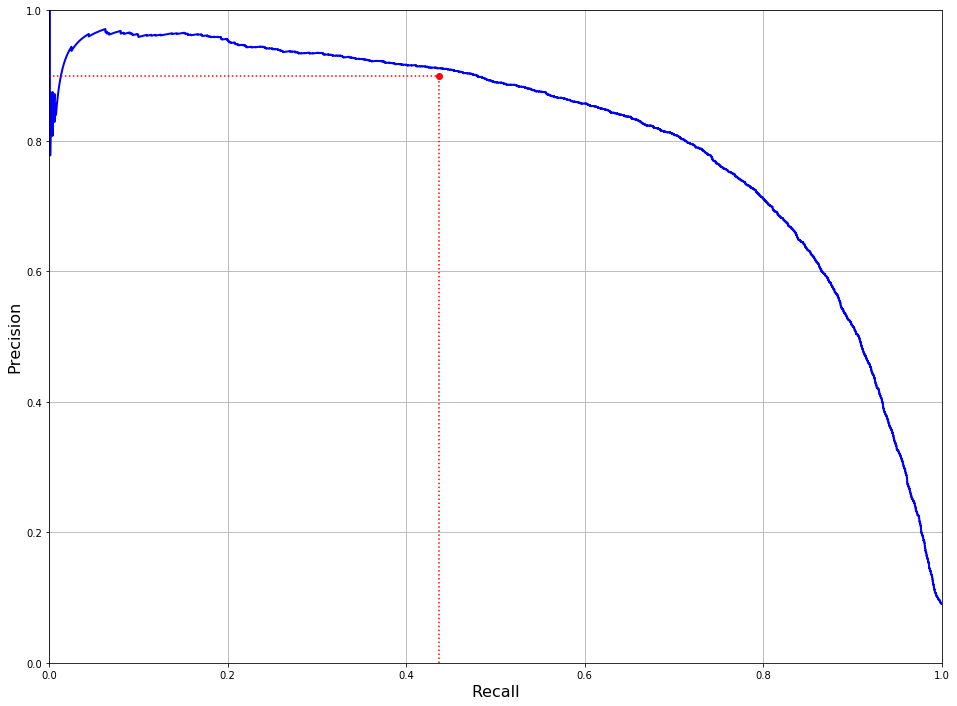

In [39]:
plt.figure(figsize=(16, 12))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (np.argmax() will give you the first index of the maximum value, which in this case means the first True value):

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [41]:
threshold_90_precision

3370.0194991439557

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let’s check these predictions’ precision and recall:

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

<div class="alert alert-warning" role="alert">
    <h4 class="alert-heading">DICA</h4>
If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”
</div>

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib.

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

This ROC curve plots the false positive rate against the true positive rate for all possible thresholds; the red circle highlights the chosen ratio (at 43.68% recall)

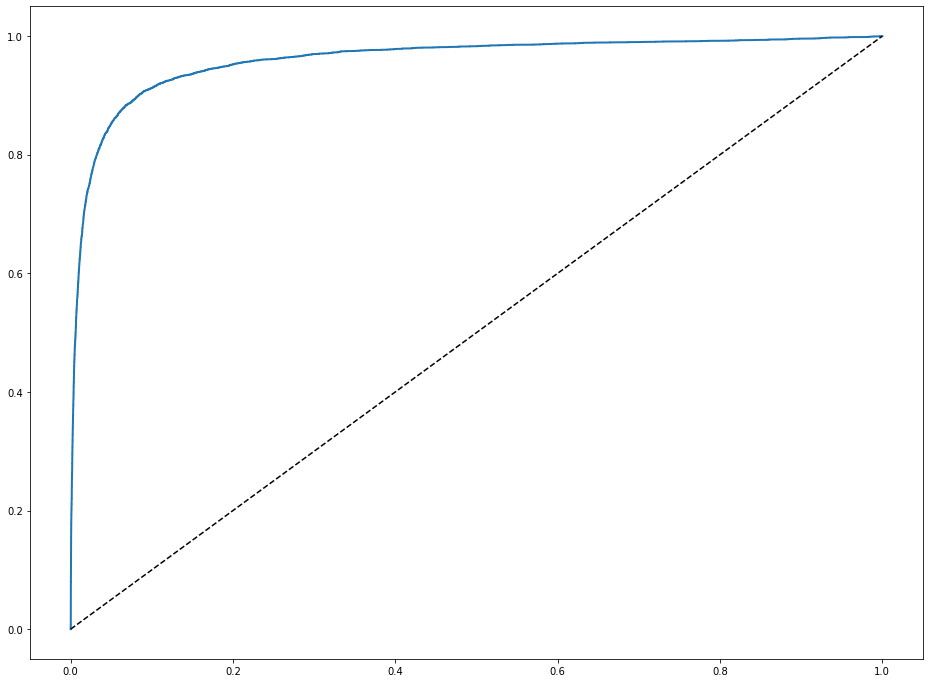

In [49]:
plt.figure(figsize=(16, 12))
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div class="alert alert-warning" role="alert">
    <h4 class="alert-heading">DICA</h4>
Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).
</div>

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities. Let’s use the positive class’s probability as the score:

In [52]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare (Figure 3-7):

Comparing ROC curves: the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC

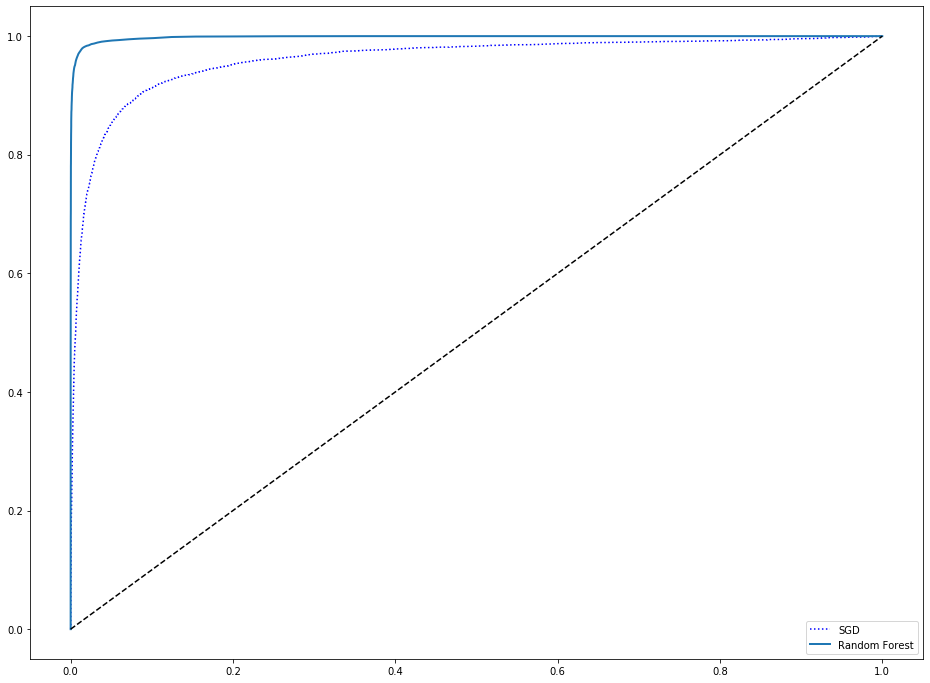

In [53]:
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As you can see in Figure 3-7, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Try measuring the precision and recall scores: you should find 99.0% precision and 86.6% recall. Not too bad!

You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now let’s try to detect more than just the 5s.

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class: